In [25]:
%matplotlib inline
import numpy as np
import matplotlib
import os
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from colorsys import rgb_to_hls
from PIL import Image
from scipy.stats import stats
sns.set(font_scale=1.5, style="ticks", color_codes=True)
plt.rcParams['figure.figsize'] = (12, 9)

In [2]:
orange_raster_dir = "/home/dat/Workspace/Thesis/orange_predictor/data/rasters_csv/2017-11-17"
csv_file = "/home/dat/Workspace/Thesis/data/Spreadsheet/Orange/orange.csv"

## Load data and calculate indices

In [3]:
df = pd.read_csv(csv_file)
df["raster_path"] = [os.path.join(orange_raster_dir, row["ID"]+".npy") for id, row in df.iterrows()]
# Remove improperly cropped images
df = df[df["ID"] != "26D"]
df = df[df["ID"] != "35E"]
df = df[df["ID"] != "42C"]
df = df[df["ID"] != "44F"]
df.describe()

,Chlorophyll,NDVI,WP
count,90.000000,84.000000,88.000000
mean,52.194292,0.823318,-8.778148
std,9.943877,0.039779,1.627238
min,25.453333,0.694674,-14.097143
25%,45.372500,0.797962,-9.510000
50%,53.576667,0.833616,-8.939643
75%,59.686750,0.852459,-7.695893
max,69.680000,0.875247,-5.288571


In [4]:
EPSILON = 1e-10

def NDVI(R, NIR):
    return (NIR - R) / (NIR + R + EPSILON)

def RedEdge(R, RE):
    return RE / (R + EPSILON)

def EVI(B, R, NIR):
    return 2.5 * (NIR - R) / (NIR + EPSILON) + 6 * R - 7.5 * B + 1 

def MCARI(G, R, RE):
    return (RE - R) - 0.23 * (RE - G) * RE / (R + EPSILON)

def GNDVI(G, NIR):
    return (NIR - G) / (NIR + G + EPSILON)

def DGCI(H, L, S):
    return ((H - 60) / 60 + (1 - S) + (1 - L)) / 3

In [5]:
ndvi, rededge, evi, mcari, gndvi, dgci, channel_vals = [], [], [], [], [], [], []
for id, row in df.iterrows():
    raster = np.load(row["raster_path"])
    # Crop border to only get tree in image
    raster = raster[10:-10, 10:-10]
    b, g, r, re, nir = np.mean(raster, axis=(0, 1))
    ndvi.append(NDVI(r, nir))
    rededge.append(RedEdge(r, re))
    evi.append(EVI(b, r, nir))
    mcari.append(MCARI(g, r, re))
    gndvi.append(GNDVI(g, nir))
    # channel_vals.append([b, g, r, re, nir])
    channel_vals.append([b, g, r])
    hls = np.zeros((raster.shape[0], raster.shape[1], 3))
    for i in range(raster.shape[0]):
        for j in range(raster.shape[1]):
            hls[i, j] = rgb_to_hls(raster[i,j,2], raster[i,j,1], raster[i,j,0])
    h, l, s = np.mean(hls, axis=(0, 1))
    dgci.append(DGCI(h, l, s))
    
df["UAV_NDVI"] = ndvi
df["RedEdge"] = rededge
df["EVI"] = evi
df["MCARI"] = mcari
df["GNDVI"] = gndvi
df["DGCI"] = dgci
df["channel_vals"] = channel_vals

In [6]:
df.head()

,ID,Chlorophyll,NDVI,WP,raster_path,UAV_NDVI,RedEdge,EVI,MCARI,GNDVI,DGCI,channel_vals
0,14E,45.130,0.790624,-8.498,/home/dat/Workspace/Thesis/orange_predictor/da...,0.371546,2.528736,1.978037,0.188396,0.140478,0.177255,"[0.19873777695021003, 0.3054054230382147, 0.18..."
1,57B,53.224,0.822390,-7.544,/home/dat/Workspace/Thesis/orange_predictor/da...,0.324222,2.621469,1.758810,0.159224,0.139444,0.202794,"[0.19854930796955372, 0.2525093503433348, 0.17..."
2,22E,63.525,0.866294,-8.279,/home/dat/Workspace/Thesis/orange_predictor/da...,0.411300,2.673086,1.961145,0.181234,0.131009,0.170312,"[0.19090055507812384, 0.28725965018248, 0.1559..."
3,51F,61.880,0.871767,-9.449,/home/dat/Workspace/Thesis/orange_predictor/da...,0.378977,3.045495,2.051799,0.134791,0.186103,0.212684,"[0.1530632325883999, 0.2096721200059737, 0.137..."
4,10H,54.390,0.840800,-9.100,/home/dat/Workspace/Thesis/orange_predictor/da...,0.407119,2.825861,2.132202,0.152705,0.200304,0.202286,"[0.16205668018057906, 0.23744553318647504, 0.1..."


In [7]:
print("NDVI & NDVI:", stats.pearsonr(df.dropna()["UAV_NDVI"], df.dropna()["NDVI"])[0])

NDVI & NDVI: 0.574340814886595


## Analyze distribution of ground truth

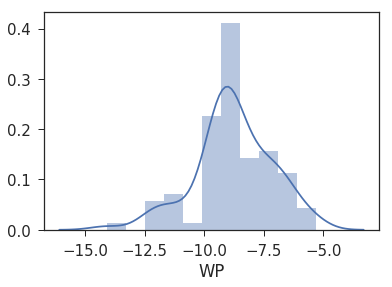

In [8]:
sns.distplot(df["WP"].dropna())

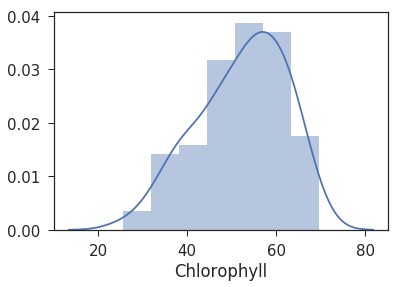

In [9]:
sns.distplot(df["Chlorophyll"].dropna())

## WP correlation with UAV indices

In [10]:
def create_scatter(x, y, x_title, y_title):
    fig = plt.figure()
    sns.regplot(x=x, y=y, fit_reg=False, label="big")
    plt.xlabel(x_title)
    plt.ylabel(y_title)

In [11]:
print("NDVI & WP:", stats.pearsonr(df.dropna()["UAV_NDVI"], df.dropna()["WP"])[0])
print("RedEdge & WP:", stats.pearsonr(df.dropna()["RedEdge"], df.dropna()["WP"])[0])
print("EVI & WP:", stats.pearsonr(df.dropna()["EVI"], df.dropna()["WP"])[0])
print("MCARI & WP:", stats.pearsonr(df.dropna()["MCARI"], df.dropna()["WP"])[0])
print("GNDVI & WP:", stats.pearsonr(df.dropna()["GNDVI"], df.dropna()["WP"])[0])
print("DGCI & WP:", stats.pearsonr(df.dropna()["DGCI"], df.dropna()["WP"])[0])

NDVI & WP: 0.4564551586264327
RedEdge & WP: 0.36524281255340757
EVI & WP: 0.4105310858223506
MCARI & WP: 0.48255713678089684
GNDVI & WP: 0.3498486389209365
DGCI & WP: -0.20421437876964355


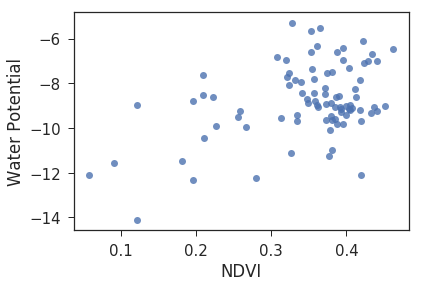

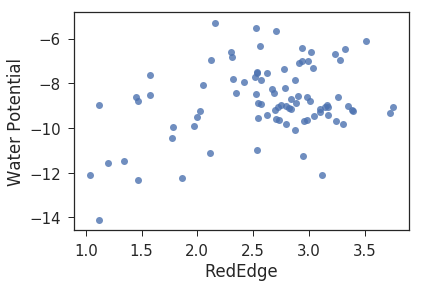

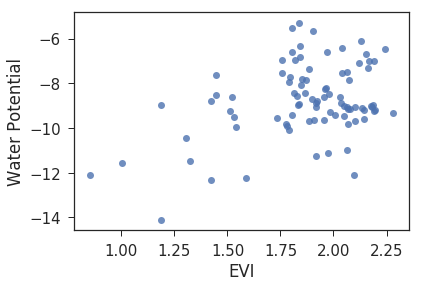

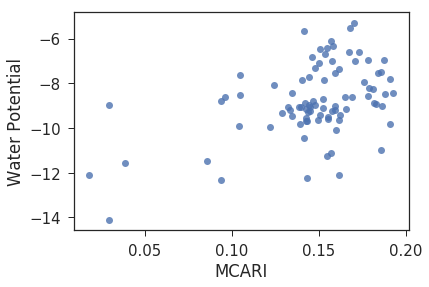

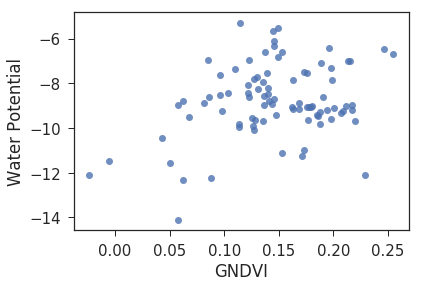

In [12]:
create_scatter(df["UAV_NDVI"], df["WP"], "NDVI", "Water Potential")
create_scatter(df["RedEdge"], df["WP"], "RedEdge", "Water Potential")
create_scatter(df["EVI"], df["WP"], "EVI", "Water Potential")
create_scatter(df["MCARI"], df["WP"], "MCARI", "Water Potential")
create_scatter(df["GNDVI"], df["WP"], "GNDVI", "Water Potential")

## Chlorophyll correlation with UAV indices

In [13]:
print("NDVI & Chlorophyll:", stats.pearsonr(df.dropna()["UAV_NDVI"], df.dropna()["Chlorophyll"])[0])
print("RedEdge & Chlorophyll:", stats.pearsonr(df.dropna()["RedEdge"], df.dropna()["Chlorophyll"])[0])
print("EVI & Chlorophyll:", stats.pearsonr(df.dropna()["EVI"], df.dropna()["Chlorophyll"])[0])
print("MCARI & Chlorophyll:", stats.pearsonr(df.dropna()["MCARI"], df.dropna()["Chlorophyll"])[0])
print("GNDVI & Chlorophyll:", stats.pearsonr(df.dropna()["GNDVI"], df.dropna()["Chlorophyll"])[0])
print("DGCI & Chlorophyll:", stats.pearsonr(df.dropna()["DGCI"], df.dropna()["Chlorophyll"])[0])

NDVI & Chlorophyll: 0.44287314232848213
RedEdge & Chlorophyll: 0.5354532693418191
EVI & Chlorophyll: 0.32858949497140744
MCARI & Chlorophyll: 0.30446332704691076
GNDVI & Chlorophyll: 0.25807834328327656
DGCI & Chlorophyll: -0.015175947366992718


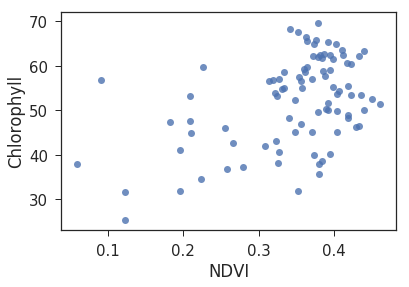

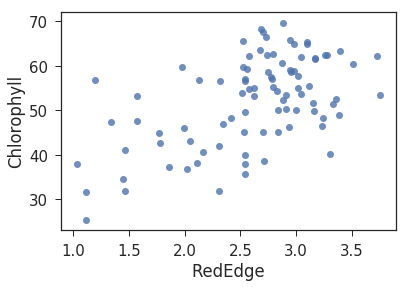

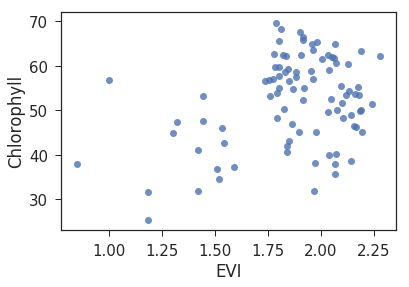

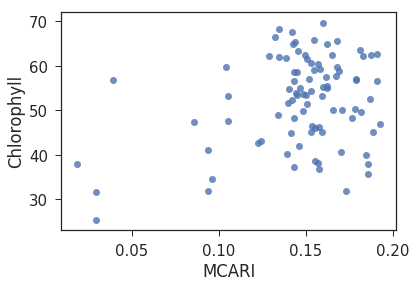

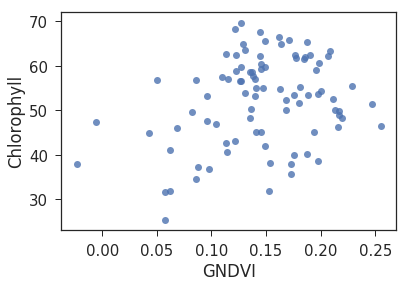

In [14]:
create_scatter(df["UAV_NDVI"], df["Chlorophyll"], "NDVI", "Chlorophyll")
create_scatter(df["RedEdge"], df["Chlorophyll"], "RedEdge", "Chlorophyll")
create_scatter(df["EVI"], df["Chlorophyll"], "EVI", "Chlorophyll")
create_scatter(df["MCARI"], df["Chlorophyll"], "MCARI", "Chlorophyll")
create_scatter(df["GNDVI"], df["Chlorophyll"], "GNDVI", "Chlorophyll")

## Learn index for WP

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle

In [16]:
def rmse(y, yhat):
    return np.sqrt(np.mean((y - yhat)**2))

def mae(y, yhat):
    return np.mean(np.abs(y - yhat))

def normalize(xs):
    max_x = max(xs)
    min_x = min(xs)
    return [(x-min_x)/(max_x-min_x) for x in xs]

def standardize(xs):
    mu = np.mean(xs)
    sigma = np.std(xs)
    
    return [(x - mu) / sigma for x in xs]

In [34]:
X = np.array(list(df.dropna()["channel_vals"]))
y = np.array(normalize(list(df.dropna()["WP"])))

X, y = shuffle(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [35]:
model = Pipeline([("poly", PolynomialFeatures(degree=1)), ("linear", LinearRegression(fit_intercept=False))])
predicted = cross_val_predict(model, X_train, y_train, cv=10)
print("RMSE:", rmse(predicted, y_train))
print("MAE:", mae(predicted, y_train))
print("R2:", r2_score(y_train, predicted))

RMSE: 0.17809103017845934
MAE: 0.14473441734977235
R2: 0.13308528204679237


In [36]:
model.fit(X_train, y_train)
predicted = model.predict(X_test)
print("RMSE:", rmse(predicted, y_test))
print("MAE:", mae(predicted, y_test))
print("R2:", r2_score(y_test, predicted))

RMSE: 0.16793959251859936
MAE: 0.13762858188420343
R2: -0.036040459703156946


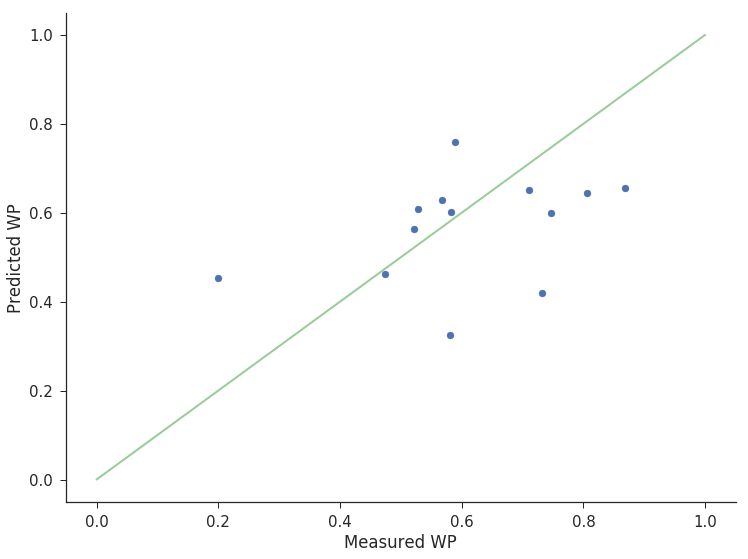

In [37]:
fig = plt.figure()
plt.scatter(y_test, predicted)
plt.plot(range(2), range(2), color="#99CC99", linewidth=2)
plt.xlabel("Measured WP")
plt.ylabel("Predicted WP")
sns.despine()
plt.savefig("wp.png")

## Learn index for chlorophyll

In [21]:
X = np.array(list(df["channel_vals"]))
y = np.array(normalize(list(df["Chlorophyll"])))

X, y = shuffle(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [22]:
model = Pipeline([("poly", PolynomialFeatures(degree=1)), ("linear", LinearRegression(fit_intercept=False))])
predicted = cross_val_predict(model, X, y, cv=10)
print("RMSE:", rmse(predicted, y))
print("MAE:", mae(predicted, y))
print("R2:", r2_score(y, predicted))

RMSE: 0.1547388434362998
MAE: 0.12353226497073468
R2: 0.5210301847786531


In [23]:
model.fit(X_train, y_train)
predicted = model.predict(X_test)
print("RMSE:", rmse(predicted, y_test))
print("MAE:", mae(predicted, y_test))
print("R2:", r2_score(y_test, predicted))

RMSE: 0.19961819426260896
MAE: 0.1655697949163367
R2: 0.43352785777530534


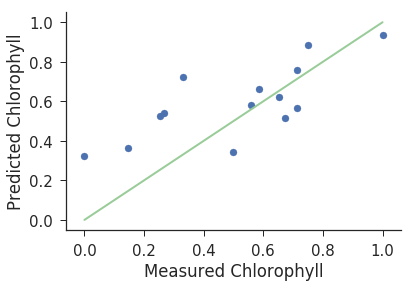

In [24]:
fig = plt.figure()
plt.scatter(y_test, predicted)
plt.plot(range(2), range(2), color="#99CC99", linewidth=2)
plt.xlabel("Measured Chlorophyll")
plt.ylabel("Predicted Chlorophyll")
sns.despine()
plt.savefig("chlorophyll.png")